In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nltk
from gensim.models.doc2vec import TaggedDocument
# put every Document with it Tag
# example ([tweet , Tag[]])
def text_with_tag(X, Tag ) :
    doc = []
    t=0
    for i in range(0,len(X)):
        # Tokenize The Words
        txt = X[i]
        #print(txt)
        tokens = nltk.wordpunct_tokenize(txt)
        doc.append(TaggedDocument(words=tokens, tags=Tag[t]))
        t += 1
    return doc

In [ ]:
########## Return feature vectors with their Target ############
def vector_for_learning(model, input_docs):
    sents = input_docs
    targets, feature_vectors = zip(*[(doc.tags, model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, feature_vectors

In [ ]:
# emmbeding data with Doc2Vec Model
train_doc = text_with_tag(x_train , y_train)
val_doc = text_with_tag(x_val , y_val)
y_train, x_train = vector_for_learning(model2,train_doc)
y_val, x_val = vector_for_learning(model2,val_doc)


In [ ]:
# Load Doc2Vec Model
from gensim.models  import Doc2Vec,Word2Vec
model2 = Doc2Vec.load("/content/drive/My Drive/OffensEval 2020/Source Code/DeepLearning_models/nlp_comp_test/doc2vec.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
import re
import codecs
def read_data(file_path):
  X = []
  Y = []
  pos_num=0
  neg_num=0
  file1= codecs.open(file_path, 'r', 'utf-8')
  for line in file1:
    if line == "nan" or line == "\n":
      continue
    out = line.split(',')
    X.append(out[0])
    label=out[1]
    if "OFF" in label:
      Y.append(1)
      pos_num+=1
    else:
      Y.append(0)
      neg_num+=1

  return X,Y, pos_num, neg_num# # read data test

# # read data test
def read_X_test(file):
  test=codecs.open(file,'r','utf-8')
  X_test=[]
  for line in test:
      X_test.append(line)
  test.close()

  return X_test



In [ ]:
x_train, y_train, pos_num, neg_num = read_data('/content/drive/My Drive/OffensEval 2020/Data/offensive_eval_subtask_A/taskA_cleaned_stemmed_train_file1.txt')
print(len(y_train))
x_val, y_val, pos_num1, neg_num1 = read_data('/content/drive/My Drive/OffensEval 2020/Data/offensive_eval_subtask_A/taskA_cleaned_stemmed_val_file1.txt')
print(len(y_val))
x_test = read_X_test('/content/drive/My Drive/OffensEval 2020/Data/test data/test_cleaned.txt')

6840
1001


In [ ]:
import numpy as np
# retrun embedding matrix [(all word in copus) ,(dimension for every word)]

def create_embedding_matrix(model, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    i=0
    for word in word_index:
      try :
        idx = word_index[word]
        word_vector = model.wv[word]
        embedding_matrix[idx] = np.array(
                      word_vector, dtype=np.float32)[:embedding_dim]

      except KeyError:
        embedding_matrix[idx]=np.random.normal(0,np.sqrt(0.25),embedding_dim)


    return embedding_matrix

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test =tokenizer.texts_to_sequences(x_test)
vocab_size = len(tokenizer.index_word) + 1

#del model

In [ ]:
embedding_matrix = create_embedding_matrix(sg_ar_twitter, tokenizer.word_index,100)


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras.preprocessing.sequence import pad_sequences
max_len = 20
x_train = pad_sequences(x_train, maxlen=max_len,truncating='post', padding='post', value = 0)
x_val = pad_sequences(x_val, maxlen=max_len,truncating='post', padding='post', value = 0)
x_test = pad_sequences(x_test, maxlen=max_len,truncating='post', padding='post', value = 0)
#print(x_train)

In [ ]:
print(x_train[1])

print(y_val[1])

[ 238   13  303  895   53 1372 3304  573   50   53   50   53  377   11
    0    0    0    0    0    0]
0


In [ ]:
import tensorflow as tf
from keras_preprocessing import sequence
from tensorflow import keras
from tensorflow.python.keras import Input
from tensorflow.python.keras.layers import Concatenate
class Attention(tf.keras.Model):
    def __init__(self):
        super(Attention, self).__init__()
       # self.W1 = tf.keras.layers.Dense(units)
        #self.W2 = tf.keras.layers.Dense(units)
        #self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

    def att(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        W1 = tf.keras.layers.Dense(1)(features)
        W2 = tf.keras.layers.Dense(1)(hidden_with_time_axis)

        score = tf.nn.tanh(W1 + W2)
        V = tf.keras.layers.Dense(1)(score)
        attention_weights = tf.nn.softmax(V, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:


sequence_input = Input(shape=(max_len,), dtype='int32')

# for one Hot Vectoring
#embedded_sequences = keras.layers.Embedding(vocab_size, 100, input_length=max_len)(sequence_input)

# for word2vec encodeing
embedded_sequences = keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_len, trainable =True)(sequence_input)


In [ ]:
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
rnn_cell_size = 256


lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM
                                     (rnn_cell_size,
                                      dropout=0.3,
                                      return_sequences=True,
                                      return_state=True,
                                      recurrent_activation='relu',
                                      recurrent_initializer='glorot_uniform'), name="bi_lstm_0")(embedded_sequences)

lstm, forward_h, forward_c, backward_h, backward_c = tf.keras.layers.Bidirectional \
    (tf.keras.layers.LSTM
     (rnn_cell_size,
      dropout=0.2,
      return_sequences=True,
      return_state=True,
      recurrent_activation='relu',
      recurrent_initializer='glorot_uniform'))(embedded_sequences)

In [ ]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
at=Attention()
context_vector, attention_weights = at.att(lstm, state_h)
#Attention(lstm, state_h)

output = keras.layers.Dense(1, activation='sigmoid')(context_vector)

model = keras.Model(inputs=sequence_input, outputs=output)

# summarize layers
print(model.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 20, 100)      2328800     input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) [(None, 20, 512), (N 731136      embedding_3[0][0]                
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 512)          0           bidirectional_6[0][1]            
                                                                 bidirectional_6[0][3]      

In [ ]:
import math
import keras.backend as K
#=tf.train.AdamOptimizer(learning_rate=0.001)
model.compile(optimizer=tf.train.AdamOptimizer( learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy',precision_m, recall_m, f1_m])

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        min_delta=0,
                                                        patience=1,
                                                        verbose=0, mode='auto')


In [ ]:
history = model.fit(x_train,
                    y_train,
                    validation_data=(x_val, y_val),
                    batch_size = 100,
                    epochs=12)

Train on 6840 samples, validate on 1001 samples
Epoch 1/12
6840/6840 [==============================] - 7s 993us/sample - loss: nan - acc: 0.3589 - precision_m: 0.2782 - recall_m: 0.8272 - f1_m: 0.3393 - val_loss: nan - val_acc: 0.1798 - val_precision_m: 0.2536 - val_recall_m: 909091.8125 - val_f1_m: 0.4563
Epoch 2/12
6840/6840 [==============================] - 4s 630us/sample - loss: nan - acc: 0.2004 - precision_m: 0.2007 - recall_m: 1.0000 - f1_m: 0.3325 - val_loss: nan - val_acc: 0.1798 - val_precision_m: 0.2536 - val_recall_m: 909091.8125 - val_f1_m: 0.4570
Epoch 3/12
6840/6840 [==============================] - 4s 629us/sample - loss: nan - acc: 0.2004 - precision_m: 0.1996 - recall_m: 1.0000 - f1_m: 0.3306 - val_loss: nan - val_acc: 0.1798 - val_precision_m: 0.2536 - val_recall_m: 909091.8125 - val_f1_m: 0.4569
Epoch 4/12
6840/6840 [==============================] - 4s 610us/sample - loss: nan - acc: 0.2004 - precision_m: 0.2004 - recall_m: 1.0000 - f1_m: 0.3326 - val_loss: nan

In [ ]:
loss, acc, precesion, recall, f1= model.evaluate(x_val, y_val)
print("Loss: ",loss)
print("acc: ",acc)
print("precesion: ",precesion)
print("recall: ",recall)
print("f1: ",f1)

1001/1001 [==============================] - 1s 637us/sample - loss: 0.3711 - acc: 0.9111 - precision_m: 0.7983 - recall_m: 0.6278 - f1_m: 0.6893
Loss:  0.37107423662424804
acc:  0.9110889
precesion:  0.79825145
recall:  0.6278217
f1:  0.6892676


In [ ]:
# Best F1_score
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

def bestThresshold(y_train,train_preds):
    tmp = [0,0,0] # idx, cur, max
    delta = 0
    for tmp[0] in tqdm(np.arange(0.1, 0.501, 0.01)):
        tmp[1] = f1_score(y_train, np.array(train_preds)>tmp[0])
        if tmp[1] > tmp[2]:
            delta = tmp[0]
            tmp[2] = tmp[1]
    print('best threshold is {:.4f} with F1 score: {:.4f}'.format(delta, tmp[2]))
    return delta , tmp[2]

valid= model.predict(x_val)

t=[ i[0] for i in valid]
delta, _= bestThresshold(y_val,t)
print(delta)
'''
max_len = 20  - > f1_score = 0.7633
----
with max_len = 30 -> F1 score: 0.7765
'''


best threshold is 0.1400 with F1 score: 0.7535
0.13999999999999999


'\nmax_len = 20  - > f1_score = 0.7633\n----\nwith max_len = 30 -> F1 score: 0.7765\n'

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd
def plot_confusion_matrix(y_test,y_pred, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  clf_report = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
  # .iloc[:-1, :] to exclude support
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

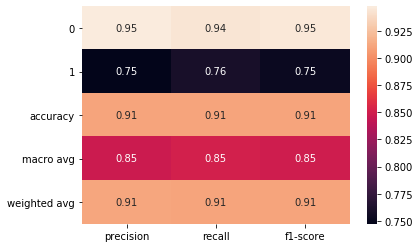

In [ ]:

def predict_with_best_threshold(y_predict , threshold):
  predict=[]
  for i in range(len(y_predict)):
    if y_predict[i] >= threshold :
      predict.append(1)
    else :
      predict.append(0)
  return predict

predicted=model.predict(x_val)
pre = predict_with_best_threshold(predicted ,delta  )
plot_confusion_matrix(y_val, pre, classes=list(set(y_val)))

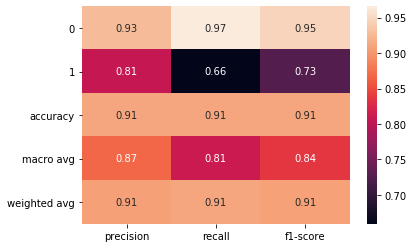

In [ ]:
# Example
# from keras.models import load_model
plot_confusion_matrix(y_val, predicted.round(), classes=list(set(y_val)))


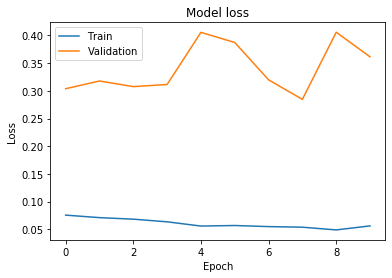

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# save the model
model.save('/content/drive/My Drive/OffensEval 2020/Models/attention_model/model_att1_stemming_maxlen=30.model')

In [ ]:
# loading arabicWord2vec model
from gensim.models  import Doc2Vec,Word2Vec

sg_ar_twitter =Word2Vec.load("/content/drive/My Drive/OffensEval 2020/Data/word2vec embedding/twitter pre_trained model /embeddings_skip_grams_100/full_grams_sg_100_twitter.mdl")


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# loading my doc2vec model
from gensim.models  import Doc2Vec,Word2Vec
model2 = Doc2Vec.load("/content/drive/My Drive/doc2vec.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
 import re
import numpy as np
import random
import os
import codecs
import csv
import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import nltk.corpus
from nltk.text import Text
from sklearn.utils import shuffle
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import accuracy_score
from nltk.stem.isri import ISRIStemmer
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import utils
import csv
from tqdm import tqdm
import multiprocessing
import nltk
# from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
from sklearn import preprocessing
from nltk.stem.isri import ISRIStemmer
tknzr = TweetTokenizer()
import csv
from sklearn import svm
from sklearn.svm import SVC
import pandas as pd
import itertools
import seaborn as sn
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import nltk.corpus
from nltk.text import Text
from sklearn.utils import shuffle
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from nltk.stem.isri import ISRIStemmer

In [ ]:
# remove harakat
def remove_harakat(in_data):
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ّ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    out_data = re.sub(noise, '', in_data)
    return out_data


# substitute some characters with others
def substitute_letters(in_data):
    out_data = re.sub("[إأٱآا]", "ا", in_data)
    out_data = re.sub("ى", "ي", out_data)
    out_data = re.sub("ؤ", "ء", out_data)
    out_data = re.sub("ئ", "ء", out_data)
    out_data = re.sub("ة", "ه", out_data)
    out_data = re.sub('URL','يورل', out_data) # this will substitute URL with arabic equivilant
    return(out_data)

# remove everything but characters, spaces and hashtags
def remove_symbols(in_data):
    pattern=r'\\.|[^\w\s]'
    out_data= re.sub(pattern,' ', in_data)
    out_data=re.sub(r'\d',' ',out_data)
    return out_data

# remove multiple spaces
def remove_spaces(in_data):
    pattern=r'\n|\r|\t|(\s+)'
    out_data= re.sub(pattern,' ', in_data)
    return out_data

# remove common stopwords
def remove_stopwords(in_data):
    in_data = tknzr.tokenize(in_data)
    out_data=[w for w in in_data if not w in stop_words ]
    result = " "
    result = result.join(out_data)
    return result

# remove duplicate consecutive characters
# don't allow more than 2 repetiation for one character at a time
def remove_duplicate_characters(in_data):
    return re.compile(r"(.)\1{2,}", re.IGNORECASE).sub("\\1", in_data)

# stemming arabic text using ISRIStemmer
def light_stem1(text):
  words = text.split()
  result = list()
  stemmer = ISRIStemmer()
  for word in words:
    word= stemmer.stem(word)
    result.append(word)

  return ' '.join(result)

def light_stem2(text):
  words = text.split()
  result = list()
  stemmer = ISRIStemmer()
  for word in words:
    word = stemmer.norm(word, num=1)      # remove diacritics which representing Arabic short vowels
    if not word in stemmer.stop_words:    # exclude stop words from being processed
      word = stemmer.pre32(word)        # remove length three and length two prefixes in this order
      word = stemmer.suf32(word)        # remove length three and length two suffixes in this order
      word = stemmer.waw(word)          # remove connective ‘و’ if it precedes a word beginning with ‘و’
      word = stemmer.norm(word, num=2)  # normalize initial hamza to bare alif
    result.append(word)
  return ' '.join(result)

def light_stem3(text):
  ArListem = ArabicLightStemmer()
  words = text.split()
  result = list()
  for word in words:
    word= ArListem.light_stem(word)
    result.append(word)

  return ' '.join(result)


# remove english characters
def remove_english_characters(in_data):
    pattern=r'[A-Za-z]'
    out_data= re.sub(pattern,'', in_data)
    return out_data

## Misc things
import codecs
pattern=r'\r\n|\n'
stop_words_file=codecs.open('/content/drive/My Drive/OffensEval 2020/Source Code/Arabic- StopWords.txt','r','utf-8')
stop_words=[]
for line in stop_words_file:
    new_line=re.sub(pattern,'',line)
    stop_words.append(new_line)
stop_words_file.close()

In [ ]:
# normalize text by using a set of functions
def normalize_text(in_data, with_stemming=False):
        clean_data=remove_harakat(in_data)# remove harakat
        clean_data=remove_symbols(clean_data)# we didn't remove # because we're going to make use of them
        clean_data=substitute_letters(clean_data)# substitute some letters with others
        clean_data= remove_english_characters(clean_data) # remove english characters

        clean_data=remove_stopwords(clean_data)# remove stop words from our text before removing harakat
        if with_stemming==True:
            clean_data=light_stem2(clean_data)
        clean_data=remove_spaces(clean_data) # remove spaces between words
        clean_data=remove_duplicate_characters(clean_data) # remove duplicate characters
        return clean_data

In [ ]:
import re
def read2(file_path):
  X = []
  Y = []
  pos_num=0
  neg_num=0
  file1= codecs.open(file_path, 'r', 'utf-8')
  for line in file1:
    if line == "nan" or line == "\n":
      continue
    out = line.split(',')
    X.append(out[0])
    label=out[1]
    if "OFF" in label:
      Y.append(1)
      pos_num+=1
    else:
      Y.append(0)
      neg_num+=1

  return X,Y, pos_num, neg_num# # read data test

def read(file):
  X=[]
  Y=[]
  file1= codecs.open(file, 'r', 'utf-8')
  for line in file1:
      if line == "nan" or line == "\n":
        continue
      else :
        if "NOT" in line :
          # negative tweet not offensive
          line = re.sub("NOT","", line) # remove not
          line = re.sub("," , "" , line) # remove ,
          X.append(line)
          Y.append(0)
        else :
          # positive tweets offensive
          line = re.sub("OFF", "", line) # remove off
          line = re.sub("," , "" , line) # remove ,
          X.append(line)
          Y.append(1)

  file1.close()
  return X, Y
# # read data test
def read_X_test():
  test=codecs.open('/content/drive/My Drive/Team Data/NLP/OffensEval 2020/Data/offensive_eval_subtask_A/OSACT2020-sharedTask-test-tweets.txt','r','utf-8')
  X_test=[]
  for line in test:
      t = normalize_text(line)
      X_test.append(t)
  test.close()

  return X_test


In [ ]:
# reading Anas Data
X_train1, y_train1, pos_num1, neg_num1 = read2('/content/drive/My Drive/OffensEval 2020/Data/offensive_eval_subtask_A/taskA_cleaned_stemmed_train_file1.txt')
print(len(y_train1), pos_num1, neg_num1, pos_num1/ len(y_train1))
X_val, y_val, pos_num_val, neg_num_val = read2('/content/drive/My Drive/OffensEval 2020/Data/offensive_eval_subtask_A/taskA_cleaned_stemmed_val_file1.txt')
print(len(y_val), pos_num_val, neg_num_val, pos_num_val/len(y_val))
X_train2, y_train2, pos_num2, neg_num2 = read2('/content/drive/My Drive/OffensEval 2020/Data/offensive_eval_subtask_A/taskA_cleaned_stemmed_train_youtube_file1.txt')
print(len(y_train2), pos_num2, neg_num2, pos_num2/len(y_train2))

6840 1371 5469 0.20043859649122808
1001 179 822 0.17882117882117882
15050 5813 9237 0.38624584717607974


In [ ]:
print(len(X_train2))
def balance(x_data, y_data, num_neg_removed):
  count=0
  new_x_data=[]
  new_y_data=[]
  for x,y in zip(x_data, y_data):
    if count>num_neg_removed:
      new_x_data.append(x)
      new_y_data.append(y)
    else:
      if y==1:
        new_x_data.append(x)
        new_y_data.append(y)
      else: count+=1

  return new_x_data, new_y_data

X_train2, y_train2=balance(X_train2, y_train2, 6000)
print(len(X_train2))
import random
X_train = X_train2 + X_train1
y_train = y_train2 + y_train1

combined = list(zip(X_train, y_train))
random.shuffle(combined)
X_train, y_train= zip(*combined)
print(len(X_train))

15050
9049
15889


In [ ]:
# # read data test
def read_X_test():
  test=codecs.open('/content/drive/My Drive/OffensEval 2020/Data/taskA_stemmed_test.txt','r','utf-8')
  X_test=[]
  for line in test:
      X_test.append(line)
  test.close()

  return X_test
X_test = read_X_test()